In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import mr_forecast as mr
import time
import random

from scipy.stats import truncnorm, powerlaw, beta, zipf, norm
from scipy.integrate import quad

%matplotlib inline

#%matplotlib notebook

## For this fake catalog, will need:
* Reasonable sets of stellar properties (Teff, logg, [Fe/H]) --- draw from Kepler target stars
* Distribution of multiplicities --- Zipfian, with parameters from our paper.
* Distribution of planet periods --- log-uniform. Check for Hill stability with each planet draw.
* Distribution of planet radii --- double-sided power law. Preference for size ordering could be enforced in the next iteration with David's mass budget idea.

## The "true" fake catalog will follow the above rules. The "false" fake catalog will not (or...(later down the line) use the real KOIs as the "fake" catalog?)

### "Wrong" fake catalog options:
* draw planet periods from uniform distribution
* draw planet radii from log-uniform distribution

### Necessary transforms: log-uniform, Zipfian, DSPL (among others).

In [2]:
def transform_uniform(x,a,b):
    return a + (b-a)*x

def transform_loguniform(x,a,b):
    la=np.log(a)
    lb=np.log(b)
    return np.exp(la + x*(lb-la))

def transform_normal(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)

def transform_beta(x,a,b):
    return beta.ppf(x,a,b)

def transform_truncated_normal(x,mu,sigma,a=0.,b=1.):
    ar, br = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.ppf(x,ar,br,loc=mu,scale=sigma)

def transform_powerlaw(x,a):
    return powerlaw.ppf(x,a+1)

def transform_zipfian(x,beta):
    #return powerlaw.ppf(x,-1-beta)
    return zipf.ppf(x,beta+1)

In [3]:
def smallplanet_prob(a_small, a_big, logRmin, logRcrit, logRmax):
    
    denom = -logRmin*(1.0+a_big) + logRcrit*(a_big-a_small) + logRmax*(1.0+a_small)
    
    sp_prob = ( (logRcrit-logRmin)*(1.0+a_big) )/denom
 
    return sp_prob


def random_smallplanet(a_small, logRmin, logRcrit):
    z = random.random() #np.random.uniform()
    
    random_smallR = z*(logRcrit - logRmin)**(1.0+a_small)
    random_smallR = logRmin + random_smallR**( 1.0/(1.0+a_small) )

    return random_smallR


def random_bigplanet(a_big, logRcrit, logRmax):
    z = random.random() #np.random.uniform()
    
    random_bigR = (1.0-z)**( 1.0/(1.0+a_big) )
    random_bigR = logRmax - random_bigR*(logRmax - logRcrit)
    
    return random_bigR



def random_planetrad(x,a_small,a_big,logRmin,logRcrit,logRmax):
    """
    return a random planet radius from a double-sided power law distribution
    """
    p_threshold = smallplanet_prob(a_small,a_big,logRmin,logRcrit,logRmax)

    if x < p_threshold:
        return random_smallplanet(a_small, logRmin, logRcrit)
    else:
        return random_bigplanet(a_big, logRcrit, logRmax)

#### Test log-uniform distribution.

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


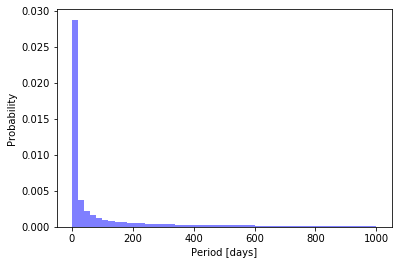

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


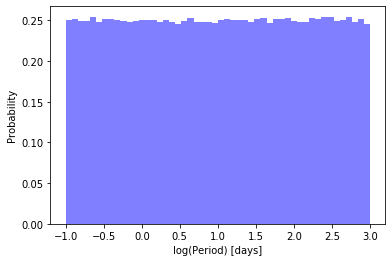

1.0


In [4]:
Pmin = 0.1 #days
Pmax = 1000. #days

random_periods = np.zeros((1000000))

for i in range(len(random_periods)):
    x = random.random() #np.random.uniform()
    random_periods[i] = transform_loguniform(x,Pmin,Pmax)

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_periods,normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("Period [days]")
plt.ylabel("Probability")
plt.show()

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(np.log10(random_periods),normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("log(Period) [days]")
plt.ylabel("Probability")
plt.show()

#check normalization
binwidths = bins[1:]-bins[0:-1]
print(np.sum(n*binwidths))

#### Test Zipfian distribution.

In [5]:
def zipf_cdf(beta_zipf,m_max):
    
    pdf = np.zeros(m_max)
    for i in range(1,m_max+1):
        pdf[i-1] = i**(-beta_zipf-1)
        
    norm = np.sum(pdf)
    
    pdf = pdf/norm
    
    cdf = np.zeros(m_max)
    
    cdf[0] = pdf[0]
    
    for i in range(2,m_max+1):
        cdf[i-1] = cdf[i-2] + pdf[i-1]
        
    return cdf

def transform_zipf(x, beta_zipf, m_max):
    cdf = zipf_cdf(beta_zipf, m_max)
    for i in range(0,m_max):
        if (x < cdf[i]):
            return i+1

10485


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


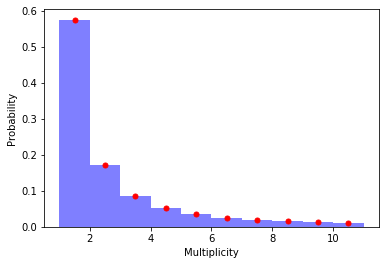

1.0


In [6]:
beta = 0.74

random_mults = np.zeros((1000000))

for i in range(len(random_mults)):
    x = random.random() #np.random.uniform()
    random_mults[i] = transform_zipf(x,beta_zipf=beta,m_max=10)

print(len(random_mults[random_mults==10]))

xs = np.arange(1,11,1)
fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_mults,normed=True,range=(1,11),bins=10,color='b',alpha=0.5)
plt.plot(xs+0.5, (xs**(-1-beta))*np.max(n),'r.',ms=10)
plt.xlabel("Multiplicity")
plt.ylabel("Probability")
plt.show()


#check normalization
binwidths = bins[1:]-bins[0:-1]
print(np.sum(n*binwidths))

In [7]:
print(np.unique(random_mults))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


#### Test DSPL transform. 
Choose some radius distribution parameters and draw a bunch of random planet radii to make sure the distribution looks right.


In [8]:
logRmin = np.log(0.5) #R_earth
logRmax = np.log(32)  #R_earth
logRcrit = np.log(2.5) #R_earth
a_small = 0.3
a_big = 4.9


random_radii = np.zeros((1000000))

for i in range(len(random_radii)):
    x = random.random() #np.random.uniform()
    random_radii[i] = random_planetrad(x,a_small,a_big,logRmin,logRcrit,logRmax)


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


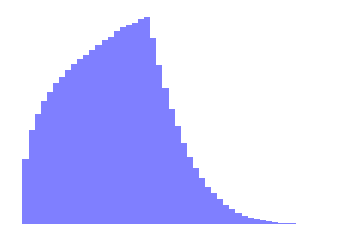

In [9]:
#small_xs = np.linspace(logRmin,logRcrit,100)
#small_ys = -0.5*(small_xs - logRmin)**(-1*a_small) + 1.02

#big_xs = (np.linspace(logRcrit+1,logRmax,100))
#big_ys = 0.6*(big_xs - logRcrit)**(-1*a_big)

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_radii,normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("log(R_p) [R_earth]")
plt.ylabel("Probability")
#plt.axvline(logRcrit,color='r',lw=2)
plt.axis("off")
plt.show()
#plt.savefig("./DSPL.pdf",fmt="pdf")

## Check for Hill stability

In [11]:
def mass_forecast_WRONG(radius):
    c1 = 0.003460532109506489
    c2 = -0.09252481979252211
    c3 = 1.2489241453022766
    c4 = -2.844669555228572
    s1= 0.279
    s2= 0.589
    s3 = -0.044
    s4 = 0.881
    t1 = 0.3096301674258988
    t2 = 2.1191926778748793
    t3 = 4.425506703276593
    t4 = 0.0
 
    logR = np.log10(radius)
    if logR < t1:
        logM = (logR - c1)/s1
    elif logR < t2:
        logM = (logR - c2)/s2
    elif logR < t3:
        logM = (logR - c3)/s3
    else:
        logM = (logR - c4)/s4
    
    
    return 10**logM

In [12]:
def mass_forecast(radius):
    """
    Extremely basic, as-deterministic-as-possible implementation of Jingjing's Forecaster code.
    Take a radius, evaluate the mass value from the Forecaster broken power law fit.
    The only probabilistic regime high Neptunian - low Stellar.
    
    R/Rearth = C * (M/Mearth)**S
    
    log(M/Mearth) = (log(R/Rearth) - logC)/S
    Parameters
    ---------
    radius : float
        Planet radius in Rearth
    Returns
    ---------
    mass : float
        Planet mass in Mearth
    """
    
    #### what is so slow about this now?????
    
    # 10**c has units of Rearth. c1 is fit; c2-c4 are derived iteratively, assuming segments meet at transition points.
    c1 = 0.003460532109506489 
    c2 = -0.09252481979252211
    c3 = 1.2489241453022766
    c4 = -2.844669555228572
    
    # power-law indices; unitless
    s1 = 0.279
    s2 = 0.589
    s3 = -0.044
    s4 = 0.881
    
    # transition points, units of log(Mearth)
    t1 = 0.3096301674258988 # log10(2.04 Mearth)                        Terran -> Neptunian
    t2 = 2.1191926778748793 # log10(0.414 Mjup * 317.828 Mearth/Mjup)   Neptunian -> Jovian
    t3 = 4.425506703276593  # log10(0.0800 Msun * 333060.4 Mearth/Msun) Jovian -> Stellar
    
    # corresponding transition points in units of log(Rearth)
    # computed from mr.Mstat2R(transition points above)
    t1_r = 0.09691001300805642 #np.log10(1.25)   Terran -> Neptunian
    t2_r = 1.1417632302757879  #np.log10(13.86)  Neptunian -> Jovian
    t3_r = 1.064083435963596   #np.log10(11.59)  Jovian -> Stellar
    
    
    logR = np.log10(radius)
    
    if logR <= t1_r: #unambiguously Terran
        logM = (logR - c1)/s1
        
    elif logR <= t3_r: #unambiguously Neptunian
        logM = (logR - c2)/s2
    
    elif logR > t2_r: #unambiguously stellar
        logM = (logR - c4)/s4
    
        
    else: # could be Neptunian, could be Jovian, could be stellar
        # based on monte carlo tests from Jingjing's code,
        # the breakdown of neptunians vs. jovians vs. stellars
        # in this radius range is:
        frac_neptunian = 0.08842
        frac_jovian = 0.839126
        frac_stellar = 0.072454
        rando = random.random() # should be significantly faster than np.random.uniform()

        if rando <= frac_neptunian: #Neptunian
            logM = (logR - c2)/s2
        elif rando <= (frac_neptunian + frac_jovian): #Jovian
            logM = (logR - c3)/s3
        else: #stellar
            logM = (logR - c4)/s4
    
    return 10.**logM #Earth masses


In [13]:
'''
def mass_forecast_jc(radius, sigma_radius):
    """
    Use Jingjing's code.
    
    Parameters
    ---------
    radius : float
        Radius in Rearth
    sigma_radius : float
        Radius uncertainty in Rearth
    
    Returns
    ---------
    mass : float
        Median predicted mass in Mearth
    """
    
    mass, massplus, massminus = mr.Rstat2M(radius, sigma_radius, unit='Earth', sample_size=1000, grid_size=1000)
    
    return mass, massplus, massminus
'''

'\ndef mass_forecast_jc(radius, sigma_radius):\n    """\n    Use Jingjing\'s code.\n    \n    Parameters\n    ---------\n    radius : float\n        Radius in Rearth\n    sigma_radius : float\n        Radius uncertainty in Rearth\n    \n    Returns\n    ---------\n    mass : float\n        Median predicted mass in Mearth\n    """\n    \n    mass, massplus, massminus = mr.Rstat2M(radius, sigma_radius, unit=\'Earth\', sample_size=1000, grid_size=1000)\n    \n    return mass, massplus, massminus\n'

In [14]:
"""
t0 = time.time()
masses = np.zeros((1))
masses = np.atleast_2d(masses)
sample_size=100

for i in range(5000):
    if i%500==0:
        print(i)
    randomRadius = np.random.uniform(11.59,13.86)
    randomRadius = truncnorm.rvs( (0.-randomRadius)/0.001, np.inf, loc=randomRadius, scale=0.001, size=int(sample_size))
    randomRadius = randomRadius[(randomRadius > 0.1) & (randomRadius < 100.)]
    m_arr = mr.Rpost2M(randomRadius, unit='Earth', classify = 'No')
    m_arr = np.atleast_2d(m_arr)

    masses = np.vstack((masses,m_arr.T))

t1 = time.time()

t = t1-t0
print(t/60.)

masses = masses[np.isfinite(masses)]
masses = masses[masses > 0.]
print(np.min(masses))
print(np.max(masses))

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(masses, color='b',alpha=0.5)
axes[0].set_xlabel("Mass [Mearth]")
axes[1].hist(np.log10(masses), color='r',alpha=0.5)
axes[1].set_xlabel("log10(Mass [Mearth])")
plt.show()

frac_neptunian = len(masses[np.log10(masses) <= 2.1191926778748793])/len(masses)
frac_jovian = len(masses[(np.log10(masses) > 2.1191926778748793) & (np.log10(masses) <= 4.425506703276593)])/len(masses)
frac_stellar = len(masses[np.log10(masses) > 4.425506703276593])/len(masses)

print(frac_neptunian)
print(frac_jovian)
print(frac_stellar)

print(frac_neptunian + frac_jovian + frac_stellar)
"""

'\nt0 = time.time()\nmasses = np.zeros((1))\nmasses = np.atleast_2d(masses)\nsample_size=100\n\nfor i in range(5000):\n    if i%500==0:\n        print(i)\n    randomRadius = np.random.uniform(11.59,13.86)\n    randomRadius = truncnorm.rvs( (0.-randomRadius)/0.001, np.inf, loc=randomRadius, scale=0.001, size=int(sample_size))\n    randomRadius = randomRadius[(randomRadius > 0.1) & (randomRadius < 100.)]\n    m_arr = mr.Rpost2M(randomRadius, unit=\'Earth\', classify = \'No\')\n    m_arr = np.atleast_2d(m_arr)\n\n    masses = np.vstack((masses,m_arr.T))\n\nt1 = time.time()\n\nt = t1-t0\nprint(t/60.)\n\nmasses = masses[np.isfinite(masses)]\nmasses = masses[masses > 0.]\nprint(np.min(masses))\nprint(np.max(masses))\n\nfig, axes = plt.subplots(1,2,figsize=(10,5))\naxes[0].hist(masses, color=\'b\',alpha=0.5)\naxes[0].set_xlabel("Mass [Mearth]")\naxes[1].hist(np.log10(masses), color=\'r\',alpha=0.5)\naxes[1].set_xlabel("log10(Mass [Mearth])")\nplt.show()\n\nfrac_neptunian = len(masses[np.log10

In [15]:
def delta_Hill(Mstar,radius1,radius2,period1,period2):
    """
    Parameters
    ---------
    Mstar : float
        Solar masses
    radius1 : float
        Earth radii
    radius2 : float
        Earth radii
    period1 : float
        Days
    period2 : float
        Days
    """
    
    mass1 = mass_forecast(radius1)
    mass2 = mass_forecast(radius2)
    
    mass_star = Mstar*332978.9015405224 #convert solar masses to Earth masses

    ratio = 2.8844991406148166/( (mass1+mass2)/mass_star )**(1./3.)
    
    
    periodx_inner = (np.min((period1,period2)))**(2./3.)
    periodx_outer = (np.max((period1,period2)))**(2./3.)
    
    dH = ratio*( (periodx_outer-periodx_inner)/(periodx_outer+periodx_inner) )
    
    return dH

In [16]:
def hill_stability(mstar,nplanets,radii,periods):
    """
    Parameters
    ---------
    mstar : float
        Stellar mass in solar masses
    nplanets : int
        Number of planets in system
    radii : np.array 
        Array of planet radii in *Earth* radii
    periods : np.array
        Array of planet periods in days
    
    Returns
    ---------
    True if stable, False if not
    """
    
    if nplanets == 1: #only one planet---always stable
        return True
    
    elif nplanets == 2:
        if delta_Hill(mstar, radii[0], radii[1], periods[0], periods[1]) > 3.4641016151377544:
            return True
        
    else:
        #assume stable until proven otherwises
        
        #test 1: go through pairs, from eq 8 of 2014ApJ...790..146F
        
        for i in range(0,nplanets-1):
            if delta_Hill(mstar, radii[i], radii[i+1], periods[i], periods[i+1]) <= 3.4641016151377544:
                return False
        
        #test 2: go through triples, from eq 9 of 2014ApJ...790..146F
        for i in range(0, nplanets-2):
            if (delta_Hill(mstar, radii[i], radii[i+1], periods[i], periods[i+1]) + 
                delta_Hill(mstar, radii[i+1], radii[i+2], periods[i+1], periods[i+2])) <= 18.:
                return False
        
        return True

In [17]:
#radii = np.concatenate((np.linspace(-1.5,2.5,1000), np.linspace(1.,1.4,1000)))
radii = np.linspace(-1.5,2.5,5000)
radii = np.sort(radii)
radii = 10.**radii

masses = np.zeros_like(radii)
masses_wrong = np.zeros_like(radii)

for i,r in enumerate(radii):
    masses[i] = mass_forecast(r)
    masses_wrong[i] = mass_forecast_WRONG(r)
    

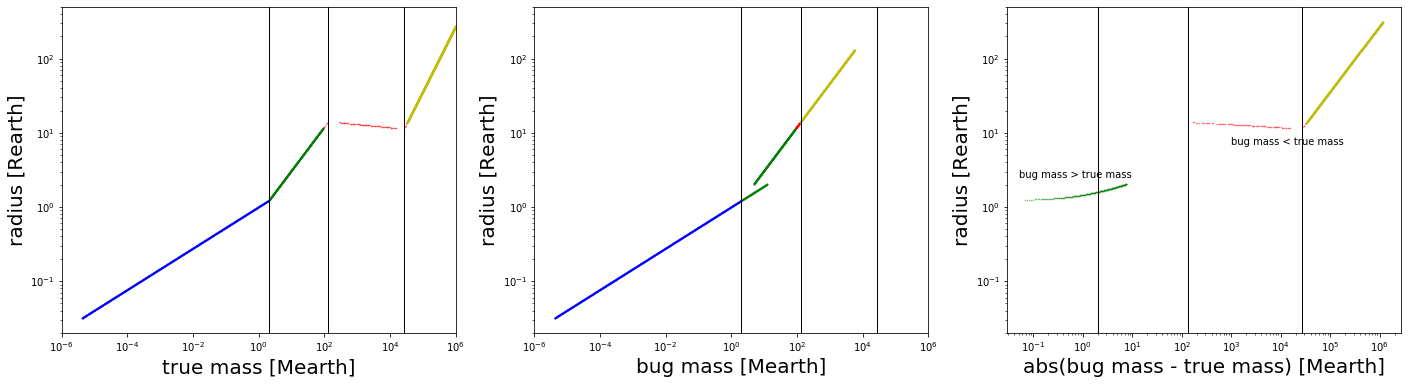

In [18]:
dmass = np.abs(masses_wrong - masses)

fig,axes = plt.subplots(1,3,figsize=(24,6))
#axes[0].plot(masses,radii,color='k',marker='.',ls='None',ms=1,alpha=0.25)
axes[0].plot(masses[radii < 1.25],radii[radii < 1.25],color='b',marker='.',ls='None',ms=1,alpha=0.5)
axes[0].plot(masses[(radii > 1.25) & (radii < 11.59)],radii[(radii > 1.25) & (radii < 11.59)],color='g',marker='.',ls='None',ms=1,alpha=0.5)
axes[0].plot(masses[(radii > 11.59) & (radii < 13.86)],radii[(radii > 11.59) & (radii < 13.86)],color='r',marker='.',ls='None',ms=1,alpha=0.5)
axes[0].plot(masses[radii > 13.86],radii[radii > 13.86],color='y',marker='.',ls='None',ms=1,alpha=0.5)

axes[0].axvline(10**0.3096301674258988,color='k',lw=1)
axes[0].axvline(10**2.1191926778748793,color='k',lw=1)
axes[0].axvline(10**4.425506703276593,color='k',lw=1)
axes[0].set_xlabel('true mass [Mearth]',fontsize=20)
axes[0].set_ylabel('radius [Rearth]',fontsize=20)
axes[0].loglog()
axes[0].set_xlim(1.e-6,1.e6)

#axes[1].plot(masses_wrong,radii,color='k',marker='.',ls='None',ms=1,alpha=0.25)
axes[1].plot(masses_wrong[radii < 1.25],radii[radii < 1.25],color='b',marker='.',ls='None',ms=1,alpha=0.5)
axes[1].plot(masses_wrong[(radii > 1.25) & (radii < 11.59)],radii[(radii > 1.25) & (radii < 11.59)],color='g',marker='.',ls='None',ms=1,alpha=0.5)
axes[1].plot(masses_wrong[(radii > 11.59) & (radii < 13.86)],radii[(radii > 11.59) & (radii < 13.86)],color='r',marker='.',ls='None',ms=1,alpha=0.5)
axes[1].plot(masses_wrong[radii > 13.86],radii[radii > 13.86],color='y',marker='.',ls='None',ms=1,alpha=0.5)

axes[1].axvline(10**0.3096301674258988,color='k',lw=1)
axes[1].axvline(10**2.1191926778748793,color='k',lw=1)
axes[1].axvline(10**4.425506703276593,color='k',lw=1)
axes[1].set_xlabel('bug mass [Mearth]',fontsize=20)
axes[1].set_ylabel('radius [Rearth]',fontsize=20)
axes[1].loglog()
axes[1].set_xlim(1.e-6,1.e6)

axes[2].plot(dmass[radii < 1.25],radii[radii < 1.25],color='b',marker='.',ls='None',ms=1,alpha=0.5)
axes[2].plot(dmass[(radii > 1.25) & (radii < 11.59)],radii[(radii > 1.25) & (radii < 11.59)],color='g',marker='.',ls='None',ms=1,alpha=0.5)
axes[2].plot(dmass[(radii > 11.59) & (radii < 13.86)],radii[(radii > 11.59) & (radii < 13.86)],color='r',marker='.',ls='None',ms=1,alpha=0.5)
axes[2].plot(dmass[radii > 13.86],radii[radii > 13.86],color='y',marker='.',ls='None',ms=1,alpha=0.5)

axes[2].axvline(10**0.3096301674258988,color='k',lw=1)
axes[2].axvline(10**2.1191926778748793,color='k',lw=1)
axes[2].axvline(10**4.425506703276593,color='k',lw=1)
axes[2].set_xlabel('abs(bug mass - true mass) [Mearth]',fontsize=20)
axes[2].set_ylabel('radius [Rearth]',fontsize=20)
axes[2].loglog()
axes[2].text(0.05,2.5,"bug mass > true mass")
axes[2].text(1e3,7,"bug mass < true mass")
#axes[2].set_xlim(1.e-6,1.e6)
#plt.show()
plt.savefig("forecaster_bug.pdf",fmt="pdf")

#fig = plt.figure(figsize=(8,6))
#plt.plot(radii,masses,color='k',marker='.',ls='None',ms=1,alpha=0.25)
#plt.axhline(10**0.3096301674258988,color='r')
#plt.axhline(10**2.1191926778748793,color='r')
#plt.axhline(10**4.425506703276593,color='r')
#plt.xlabel('radius',fontsize=20)
#plt.ylabel('mass',fontsize=20)
#plt.loglog()
#plt.show()

# Make fakes!

In [64]:
#columns: Teff, logg, [Fe/H], mass, radius
kepStellar = np.genfromtxt("../../../../kepStellar.csv",delimiter=',')
print(np.shape(kepStellar))

#remove nans
nonans = (np.isfinite(kepStellar[:,0]) & 
          np.isfinite(kepStellar[:,1]) & 
          np.isfinite(kepStellar[:,2]) & 
          np.isfinite(kepStellar[:,3]) & 
          np.isfinite(kepStellar[:,4]))
kepStellar = kepStellar[nonans]
print(np.shape(kepStellar))

#select only dwarfs
kepStellar = kepStellar[(kepStellar[:,1] > 3.) & (kepStellar[:,1] < 5.3)]
print(np.shape(kepStellar))

#select only FGKM
kepStellar = kepStellar[(kepStellar[:,0] > 2400.) & (kepStellar[:,0] < 9600.)]
print(np.shape(kepStellar))

#metallicity cut? nah
#print(np.min(kepStellar[:,2]))
#print(np.max(kepStellar[:,2]))

#mass cut
#kepStellar = kepStellar[(kepStellar[:,3] > 0.13) & (kepStellar[:,3] < 2.7)]
#print(np.shape(kepStellar))

#radius cut
#kepStellar = kepStellar[(kepStellar[:,4] > 0.14) & (kepStellar[:,4] < 7.4)]
#print(np.shape(kepStellar))


(197097, 5)
(197096, 5)
(177906, 5)
(177432, 5)


In [67]:
def grammar1systems(nsystems,
                    multmodel='zipf',
                    beta_zipf=0.80,m_max=10,
                    Pmodel='uniform',Pmin=6.25,Pmax=400.,
                    R_A=0.01, sigmaR_A = 0.005, #solar radii
                    R_B=0.05, sigmaR_B = 0.005,
                    R_C=0.1, sigmaR_C = 0.005,
                    maxAttempts=1e4):


    """
    Make "nsystems" fake planetary systems. 
    
    Grammatical rules:
    
    1. "A" ~= "article"; "B" ~= "noun" or "adjective"; "C" ~= "verb". By analogy, "A" = "the"; a "B" sequence could 
    be something like, "Doggish doggish ratty cat" or "Horsey jellyfish" or "Giraffey capybara"; "C" could be "chased"
    or "ate" or "sang" (i.e. transitive or intransitive verb). Sentences could be e.g. "A B B C A B" = "The cowy flamingo
    ate the shrimp" or "A B B B B C" = "The birdy doggy catty fish called."
    2. A "B" sequence must be preceded by an "A".
    3. The subject of a "C" verb is an "A B ... B" sequence.
    
    
    2-planet system: A B only
    3-planet system: A B C only
    4-planet system: A B B C only
    5-planet system: A B B B C or 
                     A B C A B
    6-planet system: A B B B B C or 
                     A B C A B B or 
                     A B B C A B
    7-planet system: A B B B B B C or
                     A B C A B B B or
                     A B B B C A B
    etc for 8, 9, 10---only three possibilities per.
    """
    systems = []
    systemsTrueClasses = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    allperiods = []
    alltruths = []
    for i in range(nsystems):
        print("system {0}".format(i))
        system = []
        systemTrueClasses = []
        #random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        
        mult = 0
        
        while mult < 1:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(random.random(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        print("mult is {0}".format(mult))
        multiplicities[i] = mult

        stable = False
        
        stability_check_count = 0
        while stable is False:
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            truths = np.zeros((mult))
            
            for j in range(0,mult):
                if Pmodel=="loguniform":
                    periods[j] = transform_loguniform(random.random(),Pmin,Pmax)
                elif Pmodel=="uniform":
                    periods[j] = transform_uniform(random.random(),Pmin,Pmax)
            #sort periods in increasing order
            periods = np.sort(periods)
            
            if mult <= 4:
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                #replace last radius with C
                radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                truths[-1] = 2.
            elif mult==5:
                rando = np.random.randint(low=0,high=2,size=1)
                
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                
                if rando == 0:
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                else:
                    #replace 2th radius with C
                    radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[2] = 2.
                    #replace 3th radius with A
                    radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[3] = 0.
                    
            else:
                rando = np.random.randint(low=0,high=3,size=1)
                
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                
                if rando == 0:
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                elif rando == 1:
                    #replace 2th radius with C
                    radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[2] = 2.
                    #replace 3th radius with A
                    radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A) )
                    truths[3] = 0.
                else:
                    #replace -3th radius with C
                    radii[-3] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-3] = 2.
                    #replace -2th radius with A
                    radii[-2] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[-2] = 0.
                    
            # convert solar to Earth radii for this call
            stable = hill_stability(random_star[3], mult, radii*109.2, periods)
            stability_check_count+=1
                        
            # if we can't make a stable system, get a new star and new multiplicity
            if stability_check_count > maxAttempts:
                
                random_star = kepStellar[np.random.randint(0,len(kepStellar))]

                mult = 0
                while mult < 1:
                    #random multiplicity
                    if multmodel == 'zipf':
                        mult = transform_zipf(random.random(),beta_zipf,m_max)
                    elif multmodel == 'uniform':
                        mult = np.random.choice(np.arange(1,m_max+1))

                print("mult is {0}".format(mult))
                multiplicities[i] = mult
                stability_check_count = 0
                
        print("stability check count is {0}".format(stability_check_count))

            
        #once a stable system is found:
        #[allradii.append(r/random_star[4]) for r in radii]
        [allradii.append(r) for r in radii]
        [alltruths.append(t) for t in truths]
        [allperiods.append(p) for p in periods]
        
        for j in range(0, mult):
            #planet = [radii[j]]
            #planet = [radii[j],periods[j]]
            #planet = [radii[j],random_star[0]]
            planet = [radii[j], periods[j], random_star[0], random_star[1], random_star[2]]
            
            planetTrueClass = [truths[j]]
            system.append(planet)
            systemTrueClasses.append(planetTrueClass)
        
        systems.append(system)
        systemsTrueClasses.append(systemTrueClasses)
            
    return systems,multiplicities,np.array(allradii),np.array(alltruths),systemsTrueClasses,np.array(allperiods)
    

In [68]:
def grammar2systems(nsystems,
                    multmodel='zipf',
                    beta_zipf=0.80,m_max=10,
                    Pmodel='uniform',Pmin=6.25,Pmax=400.,
                    R_A=0.01, sigmaR_A = 0.005, #solar radii
                    R_B=0.05, sigmaR_B = 0.005,
                    maxAttempts=1e4):

    """
    Make "nsystems" fake planetary systems. 
    
    Grammatical rules: Peas-in-a-pod, either terrestrials or mini-Neptunes.
    
    2-planet system: A A or B B
    3-planet system: A A A or B B B
    
    etc.
    """
    systems = []
    systemsTrueClasses = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    allperiods = []
    alltruths = []
    for i in range(nsystems):
        print("system {0}".format(i))
        system = []
        systemTrueClasses = []
        #random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        
        mult = 0
        
        while mult < 1:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(random.random(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        print("mult is {0}".format(mult))
        multiplicities[i] = mult

        stable = False
        
        stability_check_count = 0
        while stable is False:
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            truths = np.zeros((mult))
            
            for j in range(0,mult):
                if Pmodel=="loguniform":
                    periods[j] = transform_loguniform(random.random(),Pmin,Pmax)
                elif Pmodel=="uniform":
                    periods[j] = transform_uniform(random.random(),Pmin,Pmax)
            #sort periods in increasing order
            periods = np.sort(periods)
            
            rando = random.random()
            
            if rando <= 0.5:
                # populate all radii with A
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[j] = 0.
                
            else:
                # populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                    
            # convert solar to Earth radii for this call
            stable = hill_stability(random_star[3], mult, radii*109.2, periods)
            stability_check_count+=1
                        
            # if we can't make a stable system, get a new star and new multiplicity
            if stability_check_count > maxAttempts:
                
                random_star = kepStellar[np.random.randint(0,len(kepStellar))]

                mult = 0
                while mult < 1:
                    #random multiplicity
                    if multmodel == 'zipf':
                        mult = transform_zipf(random.random(),beta_zipf,m_max)
                    elif multmodel == 'uniform':
                        mult = np.random.choice(np.arange(1,m_max+1))

                print("mult is {0}".format(mult))
                multiplicities[i] = mult
                stability_check_count = 0
                
        print("stability check count is {0}".format(stability_check_count))

            
        #once a stable system is found:
        #[allradii.append(r/random_star[4]) for r in radii]
        [allradii.append(r) for r in radii]
        [alltruths.append(t) for t in truths]
        [allperiods.append(p) for p in periods]
        
        for j in range(0, mult):
            #planet = [radii[j]]
            #planet = [radii[j],periods[j]]
            #planet = [radii[j],random_star[0]]
            planet = [radii[j], periods[j], random_star[0], random_star[1], random_star[2]]
            
            planetTrueClass = [truths[j]]
            system.append(planet)
            systemTrueClasses.append(planetTrueClass)
        
        systems.append(system)
        systemsTrueClasses.append(systemTrueClasses)
            
    return systems,multiplicities,np.array(allradii),np.array(alltruths),systemsTrueClasses,np.array(allperiods)
    

In [69]:
def mixedgrammarsystems(nsystems,
                        multmodel='zipf',
                        beta_zipf=0.80,m_max=10,
                        Pmodel='uniform',Pmin=6.25,Pmax=400.,
                        Teff_cutoff=3500,
                        R_A=0.01, sigmaR_A = 0.005, #solar radii
                        R_B=0.05, sigmaR_B = 0.005,
                        R_C=0.1, sigmaR_C = 0.005,
                        maxAttempts=1e4):


    """
    Make "nsystems" fake planetary systems. 
    
    If stellar Teff <= Teff_cutoff, use grammar 2.
    Elif stellar Teff > Teff_cutoff, use grammar 1.
    
    """
    systems = []
    systemsTrueClasses = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    allperiods = []
    alltruths = []
    for i in range(nsystems):
        print("system {0}".format(i))
        system = []
        systemTrueClasses = []
        
        mult = 0
        
        while mult < 1:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(random.random(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        print("mult is {0}".format(mult))
        multiplicities[i] = mult

        stable = False
        
        stability_check_count = 0
        
        # random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        Teff = random_star[0]
        
        while stable is False:
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            truths = np.zeros((mult))
            
            for j in range(0,mult):
                if Pmodel=="loguniform":
                    periods[j] = transform_loguniform(random.random(),Pmin,Pmax)
                elif Pmodel=="uniform":
                    periods[j] = transform_uniform(random.random(),Pmin,Pmax)
            #sort periods in increasing order
            periods = np.sort(periods)
            
            # if hot star: grammar 1
            if random_star[0] > Teff_cutoff:
                if mult <= 4:
                    #populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.
                    #replace 0th radius with A
                    radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[0] = 0.
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                elif mult==5:
                    rando = np.random.randint(low=0,high=2,size=1)

                    #populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.

                    #replace 0th radius with A
                    radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[0] = 0.

                    if rando == 0:
                        #replace last radius with C
                        radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[-1] = 2.
                    else:
                        #replace 2th radius with C
                        radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[2] = 2.
                        #replace 3th radius with A
                        radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                        truths[3] = 0.

                else:
                    rando = np.random.randint(low=0,high=3,size=1)

                    #populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.

                    #replace 0th radius with A
                    radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[0] = 0.

                    if rando == 0:
                        #replace last radius with C
                        radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[-1] = 2.
                    elif rando == 1:
                        #replace 2th radius with C
                        radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[2] = 2.
                        #replace 3th radius with A
                        radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A) )
                        truths[3] = 0.
                    else:
                        #replace -3th radius with C
                        radii[-3] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[-3] = 2.
                        #replace -2th radius with A
                        radii[-2] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                        truths[-2] = 0.
            
            # if cool star: grammar 2
            else:
                rando = random.random()
                if rando <= 0.5:
                    # populate all radii with A
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                        truths[j] = 0.
                else:
                    # populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.
                        
                        
            # convert solar to Earth radii for this call
            stable = hill_stability(random_star[3], mult, radii*109.2, periods)
            stability_check_count+=1
            
            # if we can't make a stable system, get a new star and new multiplicity
            if stability_check_count > maxAttempts:
                
                random_star = kepStellar[np.random.randint(0,len(kepStellar))]

                mult = 0
                while mult < 1:
                    #random multiplicity
                    if multmodel == 'zipf':
                        mult = transform_zipf(random.random(),beta_zipf,m_max)
                    elif multmodel == 'uniform':
                        mult = np.random.choice(np.arange(1,m_max+1))

                print("mult is {0}".format(mult))
                multiplicities[i] = mult
                stability_check_count = 0
                
        print("stability check count is {0}".format(stability_check_count))

            
        #once a stable system is found:
        #[allradii.append(r/random_star[4]) for r in radii]
        [allradii.append(r) for r in radii]
        [alltruths.append(t) for t in truths]
        [allperiods.append(p) for p in periods]
        
        for j in range(0, mult):
            #planet = [radii[j]]
            #planet = [radii[j],periods[j]]
            #planet = [radii[j],random_star[0]]
            planet = [radii[j], periods[j], random_star[0], random_star[1], random_star[2]]
            
            planetTrueClass = [truths[j]]
            system.append(planet)
            systemTrueClasses.append(planetTrueClass)
        
        systems.append(system)
        systemsTrueClasses.append(systemTrueClasses)
            
    return systems,multiplicities,np.array(allradii),np.array(alltruths),systemsTrueClasses,np.array(allperiods)
    

In [70]:
def featureScale(trainingSet,n_features):
    """
    Scale each feature to have mean=0, stdev = 1
    """
    
    stacked = np.zeros((1,n_features))
    
    for i in range(0,len(trainingSet)):
        sys = trainingSet[i]
        for j in range(0,len(sys)):
            planet = np.array((sys[j]))
            stacked = np.vstack((stacked,planet))
            
    mu = np.mean(stacked,axis=0)
    sigma = np.std(stacked,axis=0)
    
    scaledTrainingSet = []
    for i in range(0,len(trainingSet)):
        sys = trainingSet[i]
        newsys = []
        for j in range(0,len(sys)):
            planet = np.array(sys[j])
            planet = (planet - mu)/sigma
            newsys.append(list(planet))
            
        scaledTrainingSet.append(newsys)
    
    return scaledTrainingSet
            

In [135]:
t0 = time.time()
nSystems=10000
experimentClass = "trainingSets"
experimentName = "mixedgrammarsoverlapping_mult=zipf_P=uniform_nsys={0}".format(nSystems)
n_features = 5

# uniform period:
# 1e4 systems = O(97 minutes) when maxAttempts = 1e4

# log-uniform period:
# 1e4 systems = O(35 minutes) when maxAttempts = 1e4
sys, mult, rad, truths, trueClassesList, pers = mixedgrammarsystems(nsystems=nSystems,
                                                                   multmodel='zipf',
                                                                   beta_zipf=0.80,m_max=10,
                                                                   Pmodel='uniform',Pmin=6.25,Pmax=400.,
                                                                   R_A=0.00917, sigmaR_A = 0.00917, #solar radii
                                                                   R_B=0.0229, sigmaR_B = 0.0229,
                                                                   R_C=0.103, sigmaR_C = 0.103,
                                                                   maxAttempts=1e4)

np.save("./{0}/{1}_truths.npy".format(experimentClass,experimentName),truths)

scaled = featureScale(sys,n_features)

with open("./{0}/{1}.txt".format(experimentClass,experimentName), "wb") as picklefile:
    pickle.dump(scaled, picklefile)

with open("./{0}/{1}_truthsOrganized.txt".format(experimentClass,experimentName), "wb") as picklefile:
    pickle.dump(trueClassesList, picklefile)

print(np.shape(truths))

t1 = time.time()

print("{0} systems in {1} minutes".format(nSystems,(t1 - t0)/60.))

system 0
mult is 1
stability check count is 1
system 1
mult is 1
stability check count is 1
system 2
mult is 1
stability check count is 1
system 3
mult is 1
stability check count is 1
system 4
mult is 1
stability check count is 1
system 5
mult is 3
stability check count is 8
system 6
mult is 10
mult is 1
stability check count is 1
system 7
mult is 1
stability check count is 1
system 8
mult is 3
stability check count is 5
system 9
mult is 2
stability check count is 1
system 10
mult is 1
stability check count is 1
system 11
mult is 1
stability check count is 1
system 12
mult is 1
stability check count is 1
system 13
mult is 5
stability check count is 1
system 14
mult is 5
stability check count is 15
system 15
mult is 1
stability check count is 1
system 16
mult is 2
stability check count is 1
system 17
mult is 1
stability check count is 1
system 18
mult is 1
stability check count is 1
system 19
mult is 1
stability check count is 1
system 20
mult is 8
stability check count is 1016
system 2

stability check count is 410
system 198
mult is 1
stability check count is 1
system 199
mult is 1
stability check count is 1
system 200
mult is 1
stability check count is 1
system 201
mult is 2
stability check count is 1
system 202
mult is 6
stability check count is 8
system 203
mult is 1
stability check count is 1
system 204
mult is 1
stability check count is 1
system 205
mult is 5
stability check count is 16
system 206
mult is 3
stability check count is 1
system 207
mult is 2
stability check count is 1
system 208
mult is 5
stability check count is 3
system 209
mult is 1
stability check count is 1
system 210
mult is 1
stability check count is 1
system 211
mult is 8
stability check count is 1110
system 212
mult is 2
stability check count is 1
system 213
mult is 1
stability check count is 1
system 214
mult is 1
stability check count is 1
system 215
mult is 1
stability check count is 1
system 216
mult is 1
stability check count is 1
system 217
mult is 1
stability check count is 1
system 

mult is 1
stability check count is 1
system 377
mult is 1
stability check count is 1
system 378
mult is 1
stability check count is 1
system 379
mult is 5
stability check count is 11
system 380
mult is 2
stability check count is 1
system 381
mult is 1
stability check count is 1
system 382
mult is 1
stability check count is 1
system 383
mult is 1
stability check count is 1
system 384
mult is 1
stability check count is 1
system 385
mult is 1
stability check count is 1
system 386
mult is 4
stability check count is 6
system 387
mult is 9
mult is 1
stability check count is 1
system 388
mult is 7
stability check count is 87
system 389
mult is 1
stability check count is 1
system 390
mult is 2
stability check count is 1
system 391
mult is 7
stability check count is 507
system 392
mult is 1
stability check count is 1
system 393
mult is 1
stability check count is 1
system 394
mult is 1
stability check count is 1
system 395
mult is 2
stability check count is 1
system 396
mult is 1
stability check 

stability check count is 12
system 561
mult is 1
stability check count is 1
system 562
mult is 1
stability check count is 1
system 563
mult is 1
stability check count is 1
system 564
mult is 2
stability check count is 1
system 565
mult is 1
stability check count is 1
system 566
mult is 1
stability check count is 1
system 567
mult is 1
stability check count is 1
system 568
mult is 1
stability check count is 1
system 569
mult is 1
stability check count is 1
system 570
mult is 5
stability check count is 36
system 571
mult is 1
stability check count is 1
system 572
mult is 4
stability check count is 30
system 573
mult is 7
stability check count is 431
system 574
mult is 3
stability check count is 1
system 575
mult is 1
stability check count is 1
system 576
mult is 2
stability check count is 1
system 577
mult is 3
stability check count is 1
system 578
mult is 2
stability check count is 1
system 579
mult is 1
stability check count is 1
system 580
mult is 1
stability check count is 1
system 5

stability check count is 291
system 752
mult is 1
stability check count is 1
system 753
mult is 4
stability check count is 9
system 754
mult is 1
stability check count is 1
system 755
mult is 1
stability check count is 1
system 756
mult is 1
stability check count is 1
system 757
mult is 1
stability check count is 1
system 758
mult is 1
stability check count is 1
system 759
mult is 3
stability check count is 1
system 760
mult is 1
stability check count is 1
system 761
mult is 4
stability check count is 5
system 762
mult is 6
stability check count is 39
system 763
mult is 4
stability check count is 1
system 764
mult is 1
stability check count is 1
system 765
mult is 4
stability check count is 6
system 766
mult is 1
stability check count is 1
system 767
mult is 4
stability check count is 4
system 768
mult is 1
stability check count is 1
system 769
mult is 1
stability check count is 1
system 770
mult is 1
stability check count is 1
system 771
mult is 1
stability check count is 1
system 772

stability check count is 3626
system 929
mult is 1
stability check count is 1
system 930
mult is 1
stability check count is 1
system 931
mult is 2
stability check count is 1
system 932
mult is 2
stability check count is 1
system 933
mult is 2
stability check count is 1
system 934
mult is 1
stability check count is 1
system 935
mult is 1
stability check count is 1
system 936
mult is 1
stability check count is 1
system 937
mult is 1
stability check count is 1
system 938
mult is 1
stability check count is 1
system 939
mult is 2
stability check count is 1
system 940
mult is 1
stability check count is 1
system 941
mult is 1
stability check count is 1
system 942
mult is 3
stability check count is 9
system 943
mult is 1
stability check count is 1
system 944
mult is 2
stability check count is 1
system 945
mult is 1
stability check count is 1
system 946
mult is 1
stability check count is 1
system 947
mult is 1
stability check count is 1
system 948
mult is 2
stability check count is 1
system 949

stability check count is 1
system 1107
mult is 1
stability check count is 1
system 1108
mult is 1
stability check count is 1
system 1109
mult is 1
stability check count is 1
system 1110
mult is 5
stability check count is 11
system 1111
mult is 1
stability check count is 1
system 1112
mult is 1
stability check count is 1
system 1113
mult is 2
stability check count is 1
system 1114
mult is 2
stability check count is 1
system 1115
mult is 10
mult is 1
stability check count is 1
system 1116
mult is 6
stability check count is 33
system 1117
mult is 1
stability check count is 1
system 1118
mult is 1
stability check count is 1
system 1119
mult is 2
stability check count is 1
system 1120
mult is 2
stability check count is 1
system 1121
mult is 1
stability check count is 1
system 1122
mult is 4
stability check count is 7
system 1123
mult is 1
stability check count is 1
system 1124
mult is 2
stability check count is 1
system 1125
mult is 3
stability check count is 9
system 1126
mult is 1
stabili

stability check count is 6191
system 1327
mult is 5
stability check count is 3
system 1328
mult is 1
stability check count is 1
system 1329
mult is 2
stability check count is 1
system 1330
mult is 2
stability check count is 1
system 1331
mult is 1
stability check count is 1
system 1332
mult is 1
stability check count is 1
system 1333
mult is 2
stability check count is 1
system 1334
mult is 2
stability check count is 1
system 1335
mult is 1
stability check count is 1
system 1336
mult is 3
stability check count is 14
system 1337
mult is 6
stability check count is 1
system 1338
mult is 7
stability check count is 126
system 1339
mult is 1
stability check count is 1
system 1340
mult is 2
stability check count is 1
system 1341
mult is 6
stability check count is 124
system 1342
mult is 1
stability check count is 1
system 1343
mult is 1
stability check count is 1
system 1344
mult is 1
stability check count is 1
system 1345
mult is 10
mult is 1
stability check count is 1
system 1346
mult is 1
s

stability check count is 703
system 1494
mult is 6
stability check count is 47
system 1495
mult is 2
stability check count is 1
system 1496
mult is 7
stability check count is 31
system 1497
mult is 1
stability check count is 1
system 1498
mult is 1
stability check count is 1
system 1499
mult is 1
stability check count is 1
system 1500
mult is 1
stability check count is 1
system 1501
mult is 2
stability check count is 1
system 1502
mult is 2
stability check count is 1
system 1503
mult is 2
stability check count is 1
system 1504
mult is 1
stability check count is 1
system 1505
mult is 1
stability check count is 1
system 1506
mult is 6
stability check count is 32
system 1507
mult is 1
stability check count is 1
system 1508
mult is 1
stability check count is 1
system 1509
mult is 2
stability check count is 1
system 1510
mult is 1
stability check count is 1
system 1511
mult is 2
stability check count is 1
system 1512
mult is 1
stability check count is 1
system 1513
mult is 1
stability check

stability check count is 59
system 1693
mult is 1
stability check count is 1
system 1694
mult is 1
stability check count is 1
system 1695
mult is 2
stability check count is 1
system 1696
mult is 9
stability check count is 3715
system 1697
mult is 1
stability check count is 1
system 1698
mult is 1
stability check count is 1
system 1699
mult is 1
stability check count is 1
system 1700
mult is 2
stability check count is 1
system 1701
mult is 2
stability check count is 1
system 1702
mult is 4
stability check count is 2
system 1703
mult is 2
stability check count is 1
system 1704
mult is 1
stability check count is 1
system 1705
mult is 1
stability check count is 1
system 1706
mult is 1
stability check count is 1
system 1707
mult is 6
stability check count is 72
system 1708
mult is 2
stability check count is 1
system 1709
mult is 1
stability check count is 1
system 1710
mult is 1
stability check count is 1
system 1711
mult is 2
stability check count is 1
system 1712
mult is 1
stability check

stability check count is 1760
system 1871
mult is 3
stability check count is 2
system 1872
mult is 1
stability check count is 1
system 1873
mult is 1
stability check count is 1
system 1874
mult is 1
stability check count is 1
system 1875
mult is 1
stability check count is 1
system 1876
mult is 6
stability check count is 11
system 1877
mult is 3
stability check count is 3
system 1878
mult is 1
stability check count is 1
system 1879
mult is 1
stability check count is 1
system 1880
mult is 1
stability check count is 1
system 1881
mult is 9
stability check count is 8495
system 1882
mult is 1
stability check count is 1
system 1883
mult is 4
stability check count is 3
system 1884
mult is 1
stability check count is 1
system 1885
mult is 1
stability check count is 1
system 1886
mult is 2
stability check count is 1
system 1887
mult is 2
stability check count is 1
system 1888
mult is 1
stability check count is 1
system 1889
mult is 1
stability check count is 1
system 1890
mult is 1
stability che

stability check count is 104
system 2076
mult is 2
stability check count is 1
system 2077
mult is 1
stability check count is 1
system 2078
mult is 1
stability check count is 1
system 2079
mult is 3
stability check count is 3
system 2080
mult is 1
stability check count is 1
system 2081
mult is 1
stability check count is 1
system 2082
mult is 1
stability check count is 1
system 2083
mult is 1
stability check count is 1
system 2084
mult is 3
stability check count is 3
system 2085
mult is 2
stability check count is 1
system 2086
mult is 1
stability check count is 1
system 2087
mult is 1
stability check count is 1
system 2088
mult is 2
stability check count is 1
system 2089
mult is 6
stability check count is 2
system 2090
mult is 1
stability check count is 1
system 2091
mult is 2
stability check count is 1
system 2092
mult is 1
stability check count is 1
system 2093
mult is 4
stability check count is 11
system 2094
mult is 2
stability check count is 1
system 2095
mult is 1
stability check c

stability check count is 3421
system 2256
mult is 6
stability check count is 35
system 2257
mult is 4
stability check count is 1
system 2258
mult is 1
stability check count is 1
system 2259
mult is 3
stability check count is 4
system 2260
mult is 1
stability check count is 1
system 2261
mult is 1
stability check count is 1
system 2262
mult is 1
stability check count is 1
system 2263
mult is 5
stability check count is 4
system 2264
mult is 2
stability check count is 1
system 2265
mult is 1
stability check count is 1
system 2266
mult is 3
stability check count is 2
system 2267
mult is 1
stability check count is 1
system 2268
mult is 3
stability check count is 4
system 2269
mult is 1
stability check count is 1
system 2270
mult is 3
stability check count is 2
system 2271
mult is 1
stability check count is 1
system 2272
mult is 1
stability check count is 1
system 2273
mult is 1
stability check count is 1
system 2274
mult is 1
stability check count is 1
system 2275
mult is 2
stability check 

mult is 1
stability check count is 1
system 2439
mult is 1
stability check count is 1
system 2440
mult is 1
stability check count is 1
system 2441
mult is 1
stability check count is 1
system 2442
mult is 2
stability check count is 1
system 2443
mult is 4
stability check count is 2
system 2444
mult is 1
stability check count is 1
system 2445
mult is 3
stability check count is 1
system 2446
mult is 3
stability check count is 1
system 2447
mult is 2
stability check count is 1
system 2448
mult is 1
stability check count is 1
system 2449
mult is 2
stability check count is 1
system 2450
mult is 1
stability check count is 1
system 2451
mult is 1
stability check count is 1
system 2452
mult is 2
stability check count is 1
system 2453
mult is 1
stability check count is 1
system 2454
mult is 1
stability check count is 1
system 2455
mult is 2
stability check count is 1
system 2456
mult is 1
stability check count is 1
system 2457
mult is 2
stability check count is 1
system 2458
mult is 1
stability 

stability check count is 339
system 2623
mult is 1
stability check count is 1
system 2624
mult is 1
stability check count is 1
system 2625
mult is 2
stability check count is 1
system 2626
mult is 1
stability check count is 1
system 2627
mult is 4
stability check count is 5
system 2628
mult is 4
stability check count is 4
system 2629
mult is 1
stability check count is 1
system 2630
mult is 1
stability check count is 1
system 2631
mult is 3
stability check count is 2
system 2632
mult is 1
stability check count is 1
system 2633
mult is 1
stability check count is 1
system 2634
mult is 1
stability check count is 1
system 2635
mult is 4
stability check count is 23
system 2636
mult is 1
stability check count is 1
system 2637
mult is 1
stability check count is 1
system 2638
mult is 1
stability check count is 1
system 2639
mult is 1
stability check count is 1
system 2640
mult is 1
stability check count is 1
system 2641
mult is 1
stability check count is 1
system 2642
mult is 2
stability check c

stability check count is 1919
system 2838
mult is 5
stability check count is 9
system 2839
mult is 2
stability check count is 1
system 2840
mult is 1
stability check count is 1
system 2841
mult is 1
stability check count is 1
system 2842
mult is 1
stability check count is 1
system 2843
mult is 1
stability check count is 1
system 2844
mult is 4
stability check count is 2
system 2845
mult is 1
stability check count is 1
system 2846
mult is 1
stability check count is 1
system 2847
mult is 6
stability check count is 56
system 2848
mult is 1
stability check count is 1
system 2849
mult is 1
stability check count is 1
system 2850
mult is 4
stability check count is 6
system 2851
mult is 1
stability check count is 1
system 2852
mult is 1
stability check count is 1
system 2853
mult is 1
stability check count is 1
system 2854
mult is 1
stability check count is 1
system 2855
mult is 1
stability check count is 1
system 2856
mult is 4
stability check count is 6
system 2857
mult is 1
stability check 

stability check count is 1154
system 3024
mult is 1
stability check count is 1
system 3025
mult is 3
stability check count is 5
system 3026
mult is 5
stability check count is 13
system 3027
mult is 1
stability check count is 1
system 3028
mult is 2
stability check count is 1
system 3029
mult is 1
stability check count is 1
system 3030
mult is 2
stability check count is 1
system 3031
mult is 2
stability check count is 1
system 3032
mult is 1
stability check count is 1
system 3033
mult is 1
stability check count is 1
system 3034
mult is 1
stability check count is 1
system 3035
mult is 2
stability check count is 1
system 3036
mult is 2
stability check count is 1
system 3037
mult is 1
stability check count is 1
system 3038
mult is 1
stability check count is 1
system 3039
mult is 1
stability check count is 1
system 3040
mult is 5
stability check count is 20
system 3041
mult is 2
stability check count is 1
system 3042
mult is 3
stability check count is 4
system 3043
mult is 1
stability check

stability check count is 426
system 3195
mult is 10
mult is 1
stability check count is 1
system 3196
mult is 5
stability check count is 1
system 3197
mult is 1
stability check count is 1
system 3198
mult is 2
stability check count is 1
system 3199
mult is 1
stability check count is 1
system 3200
mult is 1
stability check count is 1
system 3201
mult is 1
stability check count is 1
system 3202
mult is 1
stability check count is 1
system 3203
mult is 2
stability check count is 1
system 3204
mult is 3
stability check count is 1
system 3205
mult is 1
stability check count is 1
system 3206
mult is 2
stability check count is 1
system 3207
mult is 6
stability check count is 150
system 3208
mult is 1
stability check count is 1
system 3209
mult is 1
stability check count is 1
system 3210
mult is 2
stability check count is 1
system 3211
mult is 1
stability check count is 1
system 3212
mult is 1
stability check count is 1
system 3213
mult is 1
stability check count is 1
system 3214
mult is 2
stabi

stability check count is 1504
system 3396
mult is 7
stability check count is 168
system 3397
mult is 1
stability check count is 1
system 3398
mult is 4
stability check count is 3
system 3399
mult is 1
stability check count is 1
system 3400
mult is 1
stability check count is 1
system 3401
mult is 5
stability check count is 15
system 3402
mult is 2
stability check count is 1
system 3403
mult is 1
stability check count is 1
system 3404
mult is 2
stability check count is 1
system 3405
mult is 1
stability check count is 1
system 3406
mult is 1
stability check count is 1
system 3407
mult is 6
stability check count is 35
system 3408
mult is 5
stability check count is 5
system 3409
mult is 1
stability check count is 1
system 3410
mult is 1
stability check count is 1
system 3411
mult is 1
stability check count is 1
system 3412
mult is 1
stability check count is 1
system 3413
mult is 1
stability check count is 1
system 3414
mult is 1
stability check count is 1
system 3415
mult is 1
stability che

stability check count is 7249
system 3577
mult is 2
stability check count is 1
system 3578
mult is 1
stability check count is 1
system 3579
mult is 1
stability check count is 1
system 3580
mult is 2
stability check count is 1
system 3581
mult is 1
stability check count is 1
system 3582
mult is 6
stability check count is 41
system 3583
mult is 1
stability check count is 1
system 3584
mult is 1
stability check count is 1
system 3585
mult is 1
stability check count is 1
system 3586
mult is 2
stability check count is 1
system 3587
mult is 4
stability check count is 8
system 3588
mult is 1
stability check count is 1
system 3589
mult is 1
stability check count is 1
system 3590
mult is 1
stability check count is 1
system 3591
mult is 1
stability check count is 1
system 3592
mult is 1
stability check count is 1
system 3593
mult is 1
stability check count is 1
system 3594
mult is 3
stability check count is 3
system 3595
mult is 3
stability check count is 1
system 3596
mult is 2
stability check 

stability check count is 312
system 3764
mult is 8
stability check count is 730
system 3765
mult is 6
stability check count is 3
system 3766
mult is 3
stability check count is 12
system 3767
mult is 1
stability check count is 1
system 3768
mult is 1
stability check count is 1
system 3769
mult is 1
stability check count is 1
system 3770
mult is 4
stability check count is 1
system 3771
mult is 1
stability check count is 1
system 3772
mult is 2
stability check count is 1
system 3773
mult is 6
stability check count is 130
system 3774
mult is 4
stability check count is 2
system 3775
mult is 3
stability check count is 3
system 3776
mult is 1
stability check count is 1
system 3777
mult is 1
stability check count is 1
system 3778
mult is 1
stability check count is 1
system 3779
mult is 1
stability check count is 1
system 3780
mult is 2
stability check count is 1
system 3781
mult is 1
stability check count is 1
system 3782
mult is 1
stability check count is 1
system 3783
mult is 1
stability che

stability check count is 122
system 3954
mult is 1
stability check count is 1
system 3955
mult is 1
stability check count is 1
system 3956
mult is 1
stability check count is 1
system 3957
mult is 1
stability check count is 1
system 3958
mult is 3
stability check count is 2
system 3959
mult is 1
stability check count is 1
system 3960
mult is 2
stability check count is 1
system 3961
mult is 1
stability check count is 1
system 3962
mult is 1
stability check count is 1
system 3963
mult is 1
stability check count is 1
system 3964
mult is 1
stability check count is 1
system 3965
mult is 5
stability check count is 1
system 3966
mult is 4
stability check count is 6
system 3967
mult is 7
stability check count is 270
system 3968
mult is 1
stability check count is 1
system 3969
mult is 7
stability check count is 431
system 3970
mult is 2
stability check count is 1
system 3971
mult is 1
stability check count is 1
system 3972
mult is 2
stability check count is 1
system 3973
mult is 4
stability chec

stability check count is 401
system 4144
mult is 1
stability check count is 1
system 4145
mult is 1
stability check count is 1
system 4146
mult is 1
stability check count is 1
system 4147
mult is 1
stability check count is 1
system 4148
mult is 1
stability check count is 1
system 4149
mult is 1
stability check count is 1
system 4150
mult is 1
stability check count is 1
system 4151
mult is 5
stability check count is 6
system 4152
mult is 1
stability check count is 1
system 4153
mult is 3
stability check count is 7
system 4154
mult is 1
stability check count is 1
system 4155
mult is 1
stability check count is 1
system 4156
mult is 7
stability check count is 232
system 4157
mult is 8
stability check count is 3417
system 4158
mult is 6
stability check count is 175
system 4159
mult is 1
stability check count is 1
system 4160
mult is 1
stability check count is 1
system 4161
mult is 2
stability check count is 1
system 4162
mult is 1
stability check count is 1
system 4163
mult is 1
stability c

stability check count is 987
system 4342
mult is 1
stability check count is 1
system 4343
mult is 1
stability check count is 1
system 4344
mult is 1
stability check count is 1
system 4345
mult is 7
stability check count is 311
system 4346
mult is 2
stability check count is 1
system 4347
mult is 1
stability check count is 1
system 4348
mult is 1
stability check count is 1
system 4349
mult is 2
stability check count is 1
system 4350
mult is 1
stability check count is 1
system 4351
mult is 1
stability check count is 1
system 4352
mult is 1
stability check count is 1
system 4353
mult is 1
stability check count is 1
system 4354
mult is 2
stability check count is 1
system 4355
mult is 1
stability check count is 1
system 4356
mult is 2
stability check count is 1
system 4357
mult is 1
stability check count is 1
system 4358
mult is 2
stability check count is 1
system 4359
mult is 2
stability check count is 1
system 4360
mult is 1
stability check count is 1
system 4361
mult is 2
stability check 

stability check count is 34
system 4537
mult is 3
stability check count is 2
system 4538
mult is 1
stability check count is 1
system 4539
mult is 3
stability check count is 1
system 4540
mult is 1
stability check count is 1
system 4541
mult is 3
stability check count is 3
system 4542
mult is 1
stability check count is 1
system 4543
mult is 1
stability check count is 1
system 4544
mult is 2
stability check count is 1
system 4545
mult is 2
stability check count is 1
system 4546
mult is 1
stability check count is 1
system 4547
mult is 1
stability check count is 1
system 4548
mult is 3
stability check count is 9
system 4549
mult is 2
stability check count is 1
system 4550
mult is 1
stability check count is 1
system 4551
mult is 6
stability check count is 33
system 4552
mult is 2
stability check count is 1
system 4553
mult is 1
stability check count is 1
system 4554
mult is 1
stability check count is 1
system 4555
mult is 4
stability check count is 10
system 4556
mult is 1
stability check c

stability check count is 332
system 4718
mult is 2
stability check count is 1
system 4719
mult is 1
stability check count is 1
system 4720
mult is 1
stability check count is 1
system 4721
mult is 4
stability check count is 7
system 4722
mult is 3
stability check count is 3
system 4723
mult is 9
stability check count is 4398
system 4724
mult is 2
stability check count is 1
system 4725
mult is 2
stability check count is 1
system 4726
mult is 1
stability check count is 1
system 4727
mult is 2
stability check count is 1
system 4728
mult is 2
stability check count is 1
system 4729
mult is 1
stability check count is 1
system 4730
mult is 2
stability check count is 1
system 4731
mult is 1
stability check count is 1
system 4732
mult is 1
stability check count is 1
system 4733
mult is 8
stability check count is 342
system 4734
mult is 1
stability check count is 1
system 4735
mult is 1
stability check count is 1
system 4736
mult is 1
stability check count is 1
system 4737
mult is 1
stability che

stability check count is 2971
system 4890
mult is 1
stability check count is 1
system 4891
mult is 4
stability check count is 1
system 4892
mult is 1
stability check count is 1
system 4893
mult is 1
stability check count is 1
system 4894
mult is 1
stability check count is 1
system 4895
mult is 1
stability check count is 1
system 4896
mult is 1
stability check count is 1
system 4897
mult is 1
stability check count is 1
system 4898
mult is 3
stability check count is 2
system 4899
mult is 1
stability check count is 1
system 4900
mult is 4
stability check count is 22
system 4901
mult is 1
stability check count is 1
system 4902
mult is 5
stability check count is 1
system 4903
mult is 1
stability check count is 1
system 4904
mult is 2
stability check count is 1
system 4905
mult is 1
stability check count is 1
system 4906
mult is 1
stability check count is 1
system 4907
mult is 1
stability check count is 1
system 4908
mult is 1
stability check count is 1
system 4909
mult is 1
stability check 

mult is 1
stability check count is 1
system 5061
mult is 1
stability check count is 1
system 5062
mult is 2
stability check count is 1
system 5063
mult is 1
stability check count is 1
system 5064
mult is 1
stability check count is 1
system 5065
mult is 2
stability check count is 1
system 5066
mult is 1
stability check count is 1
system 5067
mult is 1
stability check count is 1
system 5068
mult is 4
stability check count is 17
system 5069
mult is 4
stability check count is 7
system 5070
mult is 1
stability check count is 1
system 5071
mult is 3
stability check count is 6
system 5072
mult is 1
stability check count is 1
system 5073
mult is 1
stability check count is 1
system 5074
mult is 2
stability check count is 1
system 5075
mult is 1
stability check count is 1
system 5076
mult is 4
stability check count is 1
system 5077
mult is 7
stability check count is 105
system 5078
mult is 3
stability check count is 1
system 5079
mult is 1
stability check count is 1
system 5080
mult is 1
stabili

stability check count is 204
system 5229
mult is 3
stability check count is 3
system 5230
mult is 3
stability check count is 12
system 5231
mult is 7
stability check count is 607
system 5232
mult is 1
stability check count is 1
system 5233
mult is 3
stability check count is 1
system 5234
mult is 2
stability check count is 1
system 5235
mult is 1
stability check count is 1
system 5236
mult is 1
stability check count is 1
system 5237
mult is 1
stability check count is 1
system 5238
mult is 6
stability check count is 33
system 5239
mult is 1
stability check count is 1
system 5240
mult is 1
stability check count is 1
system 5241
mult is 7
stability check count is 314
system 5242
mult is 1
stability check count is 1
system 5243
mult is 3
stability check count is 4
system 5244
mult is 2
stability check count is 1
system 5245
mult is 2
stability check count is 1
system 5246
mult is 1
stability check count is 1
system 5247
mult is 1
stability check count is 1
system 5248
mult is 1
stability ch

stability check count is 156
system 5428
mult is 1
stability check count is 1
system 5429
mult is 2
stability check count is 1
system 5430
mult is 1
stability check count is 1
system 5431
mult is 1
stability check count is 1
system 5432
mult is 1
stability check count is 1
system 5433
mult is 1
stability check count is 1
system 5434
mult is 3
stability check count is 2
system 5435
mult is 3
stability check count is 4
system 5436
mult is 5
stability check count is 18
system 5437
mult is 1
stability check count is 1
system 5438
mult is 1
stability check count is 1
system 5439
mult is 2
stability check count is 1
system 5440
mult is 1
stability check count is 1
system 5441
mult is 4
stability check count is 1
system 5442
mult is 1
stability check count is 1
system 5443
mult is 1
stability check count is 1
system 5444
mult is 1
stability check count is 1
system 5445
mult is 3
stability check count is 5
system 5446
mult is 1
stability check count is 1
system 5447
mult is 3
stability check c

stability check count is 713
system 5602
mult is 2
stability check count is 1
system 5603
mult is 7
stability check count is 307
system 5604
mult is 1
stability check count is 1
system 5605
mult is 1
stability check count is 1
system 5606
mult is 1
stability check count is 1
system 5607
mult is 1
stability check count is 1
system 5608
mult is 1
stability check count is 1
system 5609
mult is 2
stability check count is 1
system 5610
mult is 1
stability check count is 1
system 5611
mult is 1
stability check count is 1
system 5612
mult is 2
stability check count is 1
system 5613
mult is 1
stability check count is 1
system 5614
mult is 1
stability check count is 1
system 5615
mult is 3
stability check count is 9
system 5616
mult is 5
stability check count is 12
system 5617
mult is 1
stability check count is 1
system 5618
mult is 4
stability check count is 2
system 5619
mult is 1
stability check count is 1
system 5620
mult is 1
stability check count is 1
system 5621
mult is 1
stability check

stability check count is 90
system 5791
mult is 1
stability check count is 1
system 5792
mult is 1
stability check count is 1
system 5793
mult is 1
stability check count is 1
system 5794
mult is 1
stability check count is 1
system 5795
mult is 1
stability check count is 1
system 5796
mult is 2
stability check count is 1
system 5797
mult is 9
mult is 7
stability check count is 210
system 5798
mult is 1
stability check count is 1
system 5799
mult is 1
stability check count is 1
system 5800
mult is 1
stability check count is 1
system 5801
mult is 1
stability check count is 1
system 5802
mult is 1
stability check count is 1
system 5803
mult is 1
stability check count is 1
system 5804
mult is 8
stability check count is 739
system 5805
mult is 1
stability check count is 1
system 5806
mult is 1
stability check count is 1
system 5807
mult is 8
stability check count is 182
system 5808
mult is 1
stability check count is 1
system 5809
mult is 2
stability check count is 1
system 5810
mult is 1
sta

mult is 4
stability check count is 14
system 5959
mult is 7
stability check count is 40
system 5960
mult is 1
stability check count is 1
system 5961
mult is 1
stability check count is 1
system 5962
mult is 4
stability check count is 26
system 5963
mult is 1
stability check count is 1
system 5964
mult is 2
stability check count is 1
system 5965
mult is 1
stability check count is 1
system 5966
mult is 1
stability check count is 1
system 5967
mult is 1
stability check count is 1
system 5968
mult is 1
stability check count is 1
system 5969
mult is 1
stability check count is 1
system 5970
mult is 2
stability check count is 1
system 5971
mult is 1
stability check count is 1
system 5972
mult is 2
stability check count is 1
system 5973
mult is 1
stability check count is 1
system 5974
mult is 4
stability check count is 18
system 5975
mult is 2
stability check count is 1
system 5976
mult is 1
stability check count is 1
system 5977
mult is 3
stability check count is 1
system 5978
mult is 1
stabil

mult is 2
stability check count is 1
system 6135
mult is 1
stability check count is 1
system 6136
mult is 1
stability check count is 1
system 6137
mult is 1
stability check count is 1
system 6138
mult is 1
stability check count is 1
system 6139
mult is 1
stability check count is 1
system 6140
mult is 1
stability check count is 1
system 6141
mult is 6
stability check count is 33
system 6142
mult is 1
stability check count is 1
system 6143
mult is 2
stability check count is 1
system 6144
mult is 5
stability check count is 2
system 6145
mult is 2
stability check count is 1
system 6146
mult is 6
stability check count is 85
system 6147
mult is 1
stability check count is 1
system 6148
mult is 1
stability check count is 1
system 6149
mult is 4
stability check count is 10
system 6150
mult is 1
stability check count is 1
system 6151
mult is 1
stability check count is 1
system 6152
mult is 1
stability check count is 1
system 6153
mult is 1
stability check count is 1
system 6154
mult is 2
stabili

stability check count is 2352
system 6317
mult is 2
stability check count is 1
system 6318
mult is 1
stability check count is 1
system 6319
mult is 4
stability check count is 7
system 6320
mult is 2
stability check count is 1
system 6321
mult is 3
stability check count is 7
system 6322
mult is 1
stability check count is 1
system 6323
mult is 1
stability check count is 1
system 6324
mult is 1
stability check count is 1
system 6325
mult is 3
stability check count is 2
system 6326
mult is 2
stability check count is 1
system 6327
mult is 1
stability check count is 1
system 6328
mult is 3
stability check count is 5
system 6329
mult is 1
stability check count is 1
system 6330
mult is 6
stability check count is 28
system 6331
mult is 4
stability check count is 4
system 6332
mult is 1
stability check count is 1
system 6333
mult is 2
stability check count is 1
system 6334
mult is 1
stability check count is 1
system 6335
mult is 1
stability check count is 1
system 6336
mult is 2
stability check 

stability check count is 396
system 6497
mult is 2
stability check count is 1
system 6498
mult is 1
stability check count is 1
system 6499
mult is 1
stability check count is 1
system 6500
mult is 1
stability check count is 1
system 6501
mult is 1
stability check count is 1
system 6502
mult is 2
stability check count is 1
system 6503
mult is 2
stability check count is 1
system 6504
mult is 1
stability check count is 1
system 6505
mult is 2
stability check count is 1
system 6506
mult is 1
stability check count is 1
system 6507
mult is 1
stability check count is 1
system 6508
mult is 1
stability check count is 1
system 6509
mult is 1
stability check count is 1
system 6510
mult is 1
stability check count is 1
system 6511
mult is 1
stability check count is 1
system 6512
mult is 1
stability check count is 1
system 6513
mult is 3
stability check count is 6
system 6514
mult is 1
stability check count is 1
system 6515
mult is 3
stability check count is 3
system 6516
mult is 3
stability check co

mult is 1
stability check count is 1
system 6666
mult is 1
stability check count is 1
system 6667
mult is 4
stability check count is 3
system 6668
mult is 1
stability check count is 1
system 6669
mult is 1
stability check count is 1
system 6670
mult is 1
stability check count is 1
system 6671
mult is 1
stability check count is 1
system 6672
mult is 1
stability check count is 1
system 6673
mult is 2
stability check count is 1
system 6674
mult is 7
stability check count is 263
system 6675
mult is 8
stability check count is 2078
system 6676
mult is 1
stability check count is 1
system 6677
mult is 1
stability check count is 1
system 6678
mult is 1
stability check count is 1
system 6679
mult is 4
stability check count is 1
system 6680
mult is 1
stability check count is 1
system 6681
mult is 1
stability check count is 1
system 6682
mult is 5
stability check count is 16
system 6683
mult is 4
stability check count is 3
system 6684
mult is 8
stability check count is 4080
system 6685
mult is 2
s

stability check count is 316
system 6843
mult is 1
stability check count is 1
system 6844
mult is 1
stability check count is 1
system 6845
mult is 10
mult is 1
stability check count is 1
system 6846
mult is 1
stability check count is 1
system 6847
mult is 3
stability check count is 6
system 6848
mult is 2
stability check count is 1
system 6849
mult is 7
stability check count is 617
system 6850
mult is 4
stability check count is 1
system 6851
mult is 1
stability check count is 1
system 6852
mult is 2
stability check count is 1
system 6853
mult is 2
stability check count is 1
system 6854
mult is 4
stability check count is 12
system 6855
mult is 1
stability check count is 1
system 6856
mult is 1
stability check count is 1
system 6857
mult is 1
stability check count is 1
system 6858
mult is 1
stability check count is 1
system 6859
mult is 1
stability check count is 1
system 6860
mult is 1
stability check count is 1
system 6861
mult is 1
stability check count is 1
system 6862
mult is 4
stab

stability check count is 5365
system 7010
mult is 1
stability check count is 1
system 7011
mult is 1
stability check count is 1
system 7012
mult is 1
stability check count is 1
system 7013
mult is 1
stability check count is 1
system 7014
mult is 1
stability check count is 1
system 7015
mult is 1
stability check count is 1
system 7016
mult is 1
stability check count is 1
system 7017
mult is 1
stability check count is 1
system 7018
mult is 2
stability check count is 1
system 7019
mult is 1
stability check count is 1
system 7020
mult is 1
stability check count is 1
system 7021
mult is 1
stability check count is 1
system 7022
mult is 3
stability check count is 2
system 7023
mult is 1
stability check count is 1
system 7024
mult is 1
stability check count is 1
system 7025
mult is 1
stability check count is 1
system 7026
mult is 1
stability check count is 1
system 7027
mult is 1
stability check count is 1
system 7028
mult is 1
stability check count is 1
system 7029
mult is 1
stability check c

stability check count is 1
system 7207
mult is 1
stability check count is 1
system 7208
mult is 1
stability check count is 1
system 7209
mult is 1
stability check count is 1
system 7210
mult is 1
stability check count is 1
system 7211
mult is 1
stability check count is 1
system 7212
mult is 2
stability check count is 1
system 7213
mult is 1
stability check count is 1
system 7214
mult is 9
stability check count is 3661
system 7215
mult is 1
stability check count is 1
system 7216
mult is 1
stability check count is 1
system 7217
mult is 3
stability check count is 3
system 7218
mult is 7
stability check count is 204
system 7219
mult is 1
stability check count is 1
system 7220
mult is 2
stability check count is 1
system 7221
mult is 1
stability check count is 1
system 7222
mult is 1
stability check count is 1
system 7223
mult is 1
stability check count is 1
system 7224
mult is 8
stability check count is 68
system 7225
mult is 5
stability check count is 25
system 7226
mult is 2
stability che

stability check count is 787
system 7384
mult is 3
stability check count is 2
system 7385
mult is 1
stability check count is 1
system 7386
mult is 1
stability check count is 1
system 7387
mult is 1
stability check count is 1
system 7388
mult is 3
stability check count is 4
system 7389
mult is 2
stability check count is 1
system 7390
mult is 1
stability check count is 1
system 7391
mult is 5
stability check count is 8
system 7392
mult is 2
stability check count is 1
system 7393
mult is 1
stability check count is 1
system 7394
mult is 2
stability check count is 1
system 7395
mult is 1
stability check count is 1
system 7396
mult is 1
stability check count is 1
system 7397
mult is 1
stability check count is 1
system 7398
mult is 8
stability check count is 2409
system 7399
mult is 6
stability check count is 9
system 7400
mult is 3
stability check count is 1
system 7401
mult is 4
stability check count is 31
system 7402
mult is 2
stability check count is 1
system 7403
mult is 3
stability chec

mult is 7
stability check count is 91
system 7553
mult is 2
stability check count is 1
system 7554
mult is 1
stability check count is 1
system 7555
mult is 4
stability check count is 16
system 7556
mult is 1
stability check count is 1
system 7557
mult is 2
stability check count is 1
system 7558
mult is 1
stability check count is 1
system 7559
mult is 1
stability check count is 1
system 7560
mult is 2
stability check count is 1
system 7561
mult is 3
stability check count is 5
system 7562
mult is 4
stability check count is 1
system 7563
mult is 4
stability check count is 11
system 7564
mult is 4
stability check count is 27
system 7565
mult is 1
stability check count is 1
system 7566
mult is 2
stability check count is 1
system 7567
mult is 1
stability check count is 1
system 7568
mult is 1
stability check count is 1
system 7569
mult is 1
stability check count is 1
system 7570
mult is 1
stability check count is 1
system 7571
mult is 7
stability check count is 210
system 7572
mult is 6
stab

stability check count is 4751
system 7727
mult is 1
stability check count is 1
system 7728
mult is 1
stability check count is 1
system 7729
mult is 1
stability check count is 1
system 7730
mult is 2
stability check count is 1
system 7731
mult is 1
stability check count is 1
system 7732
mult is 1
stability check count is 1
system 7733
mult is 1
stability check count is 1
system 7734
mult is 2
stability check count is 1
system 7735
mult is 6
stability check count is 355
system 7736
mult is 1
stability check count is 1
system 7737
mult is 7
stability check count is 69
system 7738
mult is 1
stability check count is 1
system 7739
mult is 1
stability check count is 1
system 7740
mult is 6
stability check count is 46
system 7741
mult is 1
stability check count is 1
system 7742
mult is 1
stability check count is 1
system 7743
mult is 1
stability check count is 1
system 7744
mult is 9
stability check count is 2748
system 7745
mult is 6
stability check count is 48
system 7746
mult is 1
stability

mult is 1
stability check count is 1
system 7897
mult is 1
stability check count is 1
system 7898
mult is 1
stability check count is 1
system 7899
mult is 1
stability check count is 1
system 7900
mult is 1
stability check count is 1
system 7901
mult is 9
mult is 2
stability check count is 1
system 7902
mult is 5
stability check count is 2
system 7903
mult is 1
stability check count is 1
system 7904
mult is 1
stability check count is 1
system 7905
mult is 7
stability check count is 260
system 7906
mult is 1
stability check count is 1
system 7907
mult is 1
stability check count is 1
system 7908
mult is 1
stability check count is 1
system 7909
mult is 1
stability check count is 1
system 7910
mult is 1
stability check count is 1
system 7911
mult is 2
stability check count is 1
system 7912
mult is 1
stability check count is 1
system 7913
mult is 1
stability check count is 1
system 7914
mult is 2
stability check count is 1
system 7915
mult is 1
stability check count is 1
system 7916
mult is 

stability check count is 99
system 8112
mult is 1
stability check count is 1
system 8113
mult is 2
stability check count is 1
system 8114
mult is 1
stability check count is 1
system 8115
mult is 1
stability check count is 1
system 8116
mult is 5
stability check count is 39
system 8117
mult is 1
stability check count is 1
system 8118
mult is 1
stability check count is 1
system 8119
mult is 1
stability check count is 1
system 8120
mult is 1
stability check count is 1
system 8121
mult is 1
stability check count is 1
system 8122
mult is 1
stability check count is 1
system 8123
mult is 1
stability check count is 1
system 8124
mult is 1
stability check count is 1
system 8125
mult is 3
stability check count is 2
system 8126
mult is 1
stability check count is 1
system 8127
mult is 2
stability check count is 1
system 8128
mult is 2
stability check count is 1
system 8129
mult is 1
stability check count is 1
system 8130
mult is 5
stability check count is 34
system 8131
mult is 4
stability check c

stability check count is 431
system 8287
mult is 3
stability check count is 3
system 8288
mult is 1
stability check count is 1
system 8289
mult is 1
stability check count is 1
system 8290
mult is 1
stability check count is 1
system 8291
mult is 1
stability check count is 1
system 8292
mult is 7
stability check count is 389
system 8293
mult is 3
stability check count is 2
system 8294
mult is 1
stability check count is 1
system 8295
mult is 1
stability check count is 1
system 8296
mult is 2
stability check count is 1
system 8297
mult is 4
stability check count is 2
system 8298
mult is 7
stability check count is 719
system 8299
mult is 1
stability check count is 1
system 8300
mult is 4
stability check count is 9
system 8301
mult is 3
stability check count is 2
system 8302
mult is 2
stability check count is 1
system 8303
mult is 4
stability check count is 1
system 8304
mult is 1
stability check count is 1
system 8305
mult is 1
stability check count is 1
system 8306
mult is 1
stability chec

stability check count is 241
system 8464
mult is 1
stability check count is 1
system 8465
mult is 1
stability check count is 1
system 8466
mult is 1
stability check count is 1
system 8467
mult is 2
stability check count is 1
system 8468
mult is 1
stability check count is 1
system 8469
mult is 7
stability check count is 172
system 8470
mult is 1
stability check count is 1
system 8471
mult is 4
stability check count is 1
system 8472
mult is 3
stability check count is 4
system 8473
mult is 1
stability check count is 1
system 8474
mult is 2
stability check count is 1
system 8475
mult is 1
stability check count is 1
system 8476
mult is 7
stability check count is 1864
system 8477
mult is 2
stability check count is 1
system 8478
mult is 1
stability check count is 1
system 8479
mult is 1
stability check count is 1
system 8480
mult is 10
mult is 2
stability check count is 1
system 8481
mult is 2
stability check count is 1
system 8482
mult is 1
stability check count is 1
system 8483
mult is 3
st

stability check count is 212
system 8643
mult is 5
stability check count is 38
system 8644
mult is 3
stability check count is 2
system 8645
mult is 1
stability check count is 1
system 8646
mult is 1
stability check count is 1
system 8647
mult is 1
stability check count is 1
system 8648
mult is 1
stability check count is 1
system 8649
mult is 2
stability check count is 1
system 8650
mult is 1
stability check count is 1
system 8651
mult is 1
stability check count is 1
system 8652
mult is 9
stability check count is 4042
system 8653
mult is 6
stability check count is 59
system 8654
mult is 1
stability check count is 1
system 8655
mult is 1
stability check count is 1
system 8656
mult is 1
stability check count is 1
system 8657
mult is 4
stability check count is 4
system 8658
mult is 1
stability check count is 1
system 8659
mult is 1
stability check count is 1
system 8660
mult is 1
stability check count is 1
system 8661
mult is 1
stability check count is 1
system 8662
mult is 1
stability che

stability check count is 2922
system 8823
mult is 1
stability check count is 1
system 8824
mult is 1
stability check count is 1
system 8825
mult is 2
stability check count is 1
system 8826
mult is 6
stability check count is 147
system 8827
mult is 1
stability check count is 1
system 8828
mult is 5
stability check count is 22
system 8829
mult is 1
stability check count is 1
system 8830
mult is 2
stability check count is 1
system 8831
mult is 3
stability check count is 3
system 8832
mult is 1
stability check count is 1
system 8833
mult is 1
stability check count is 1
system 8834
mult is 2
stability check count is 1
system 8835
mult is 6
stability check count is 106
system 8836
mult is 2
stability check count is 1
system 8837
mult is 1
stability check count is 1
system 8838
mult is 2
stability check count is 1
system 8839
mult is 7
stability check count is 160
system 8840
mult is 1
stability check count is 1
system 8841
mult is 1
stability check count is 1
system 8842
mult is 2
stability 

stability check count is 480
system 8995
mult is 2
stability check count is 1
system 8996
mult is 1
stability check count is 1
system 8997
mult is 1
stability check count is 1
system 8998
mult is 4
stability check count is 3
system 8999
mult is 3
stability check count is 12
system 9000
mult is 1
stability check count is 1
system 9001
mult is 1
stability check count is 1
system 9002
mult is 2
stability check count is 1
system 9003
mult is 1
stability check count is 1
system 9004
mult is 1
stability check count is 1
system 9005
mult is 2
stability check count is 1
system 9006
mult is 2
stability check count is 1
system 9007
mult is 2
stability check count is 1
system 9008
mult is 4
stability check count is 1
system 9009
mult is 1
stability check count is 1
system 9010
mult is 1
stability check count is 1
system 9011
mult is 1
stability check count is 1
system 9012
mult is 1
stability check count is 1
system 9013
mult is 4
stability check count is 2
system 9014
mult is 1
stability check c

mult is 1
stability check count is 1
system 9172
mult is 4
stability check count is 15
system 9173
mult is 4
stability check count is 10
system 9174
mult is 1
stability check count is 1
system 9175
mult is 1
stability check count is 1
system 9176
mult is 5
stability check count is 7
system 9177
mult is 2
stability check count is 1
system 9178
mult is 1
stability check count is 1
system 9179
mult is 4
stability check count is 1
system 9180
mult is 1
stability check count is 1
system 9181
mult is 2
stability check count is 1
system 9182
mult is 1
stability check count is 1
system 9183
mult is 1
stability check count is 1
system 9184
mult is 1
stability check count is 1
system 9185
mult is 3
stability check count is 2
system 9186
mult is 3
stability check count is 2
system 9187
mult is 3
stability check count is 3
system 9188
mult is 1
stability check count is 1
system 9189
mult is 1
stability check count is 1
system 9190
mult is 1
stability check count is 1
system 9191
mult is 3
stabilit

stability check count is 27
system 9352
mult is 1
stability check count is 1
system 9353
mult is 3
stability check count is 7
system 9354
mult is 1
stability check count is 1
system 9355
mult is 4
stability check count is 7
system 9356
mult is 2
stability check count is 1
system 9357
mult is 1
stability check count is 1
system 9358
mult is 2
stability check count is 1
system 9359
mult is 1
stability check count is 1
system 9360
mult is 3
stability check count is 1
system 9361
mult is 3
stability check count is 2
system 9362
mult is 7
stability check count is 184
system 9363
mult is 1
stability check count is 1
system 9364
mult is 2
stability check count is 1
system 9365
mult is 2
stability check count is 1
system 9366
mult is 1
stability check count is 1
system 9367
mult is 1
stability check count is 1
system 9368
mult is 1
stability check count is 1
system 9369
mult is 3
stability check count is 1
system 9370
mult is 4
stability check count is 20
system 9371
mult is 1
stability check 

stability check count is 83
system 9528
mult is 1
stability check count is 1
system 9529
mult is 1
stability check count is 1
system 9530
mult is 3
stability check count is 2
system 9531
mult is 2
stability check count is 1
system 9532
mult is 3
stability check count is 7
system 9533
mult is 3
stability check count is 1
system 9534
mult is 1
stability check count is 1
system 9535
mult is 2
stability check count is 1
system 9536
mult is 1
stability check count is 1
system 9537
mult is 1
stability check count is 1
system 9538
mult is 6
stability check count is 6
system 9539
mult is 1
stability check count is 1
system 9540
mult is 1
stability check count is 1
system 9541
mult is 3
stability check count is 4
system 9542
mult is 1
stability check count is 1
system 9543
mult is 1
stability check count is 1
system 9544
mult is 1
stability check count is 1
system 9545
mult is 2
stability check count is 1
system 9546
mult is 1
stability check count is 1
system 9547
mult is 1
stability check cou

mult is 1
stability check count is 1
system 9720
mult is 3
stability check count is 3
system 9721
mult is 1
stability check count is 1
system 9722
mult is 1
stability check count is 1
system 9723
mult is 2
stability check count is 1
system 9724
mult is 1
stability check count is 1
system 9725
mult is 1
stability check count is 1
system 9726
mult is 8
stability check count is 370
system 9727
mult is 1
stability check count is 1
system 9728
mult is 5
stability check count is 1
system 9729
mult is 2
stability check count is 1
system 9730
mult is 4
stability check count is 2
system 9731
mult is 1
stability check count is 1
system 9732
mult is 10
mult is 1
stability check count is 1
system 9733
mult is 1
stability check count is 1
system 9734
mult is 1
stability check count is 1
system 9735
mult is 1
stability check count is 1
system 9736
mult is 1
stability check count is 1
system 9737
mult is 1
stability check count is 1
system 9738
mult is 3
stability check count is 3
system 9739
mult is

mult is 2
stability check count is 1
system 9888
mult is 1
stability check count is 1
system 9889
mult is 1
stability check count is 1
system 9890
mult is 2
stability check count is 1
system 9891
mult is 3
stability check count is 4
system 9892
mult is 2
stability check count is 1
system 9893
mult is 1
stability check count is 1
system 9894
mult is 1
stability check count is 1
system 9895
mult is 4
stability check count is 7
system 9896
mult is 2
stability check count is 1
system 9897
mult is 1
stability check count is 1
system 9898
mult is 3
stability check count is 9
system 9899
mult is 1
stability check count is 1
system 9900
mult is 1
stability check count is 1
system 9901
mult is 5
stability check count is 26
system 9902
mult is 1
stability check count is 1
system 9903
mult is 1
stability check count is 1
system 9904
mult is 1
stability check count is 1
system 9905
mult is 1
stability check count is 1
system 9906
mult is 1
stability check count is 1
system 9907
mult is 1
stability

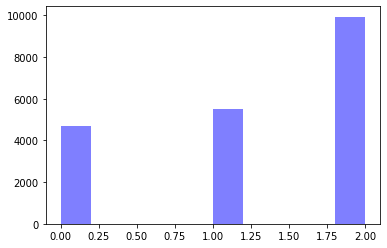

In [136]:
plt.hist(truths,color='b',range=(0.,2.),bins=10,alpha=0.5)
plt.show()

In [137]:
print(type(sys[0]))
print(len(sys[0]))

print(type(sys[0][0]))
print(len(sys[0][0]))

print(mult[0])
print(sys[0])
print(sys[0][0])

<class 'list'>
1
<class 'list'>
5
1.0
[[0.20945972395366574, 185.56540691585968, 5529.0, 4.464, -0.48]]
[0.20945972395366574, 185.56540691585968, 5529.0, 4.464, -0.48]


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


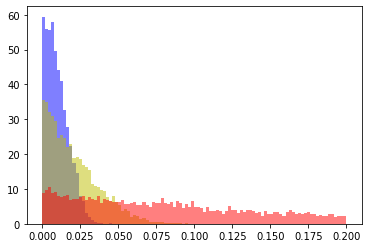

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


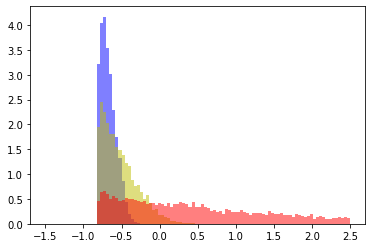

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


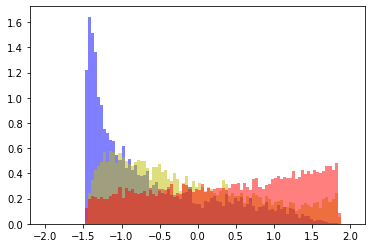

-1.4636683800816808
1.8469909075056206
[]


In [138]:
plt.hist(np.array(rad[truths==0]),normed=True,range=(0,0.2),bins=100,color='b',alpha=0.5)
plt.hist(np.array(rad[truths==1]),normed=True,range=(0,0.2),bins=100,color='y',alpha=0.5)
plt.hist(np.array(rad[truths==2]),normed=True,range=(0,0.2),bins=100,color='r',alpha=0.5)
plt.show()

scaledRad = (rad - np.mean(rad))/np.std(rad)
plt.hist(np.array(scaledRad[truths==0]),normed=True,range=(-1.5,2.5),bins=100,color='b',alpha=0.5)
plt.hist(np.array(scaledRad[truths==1]),normed=True,range=(-1.5,2.5),bins=100,color='y',alpha=0.5)
plt.hist(np.array(scaledRad[truths==2]),normed=True,range=(-1.5,2.5),bins=100,color='r',alpha=0.5)
plt.show()

scaledPer = (pers - np.mean(pers))/np.std(pers)
plt.hist(np.array(scaledPer[truths==0]),normed=True,range=(-2.,2.),bins=100,color='b',alpha=0.5)
plt.hist(np.array(scaledPer[truths==1]),normed=True,range=(-2.,2.),bins=100,color='y',alpha=0.5)
plt.hist(np.array(scaledPer[truths==2]),normed=True,range=(-2.,2.),bins=100,color='r',alpha=0.5)
plt.show()

print(np.min(scaledPer))
print(np.max(scaledPer))
print(scaledPer[np.isnan(scaledPer)])

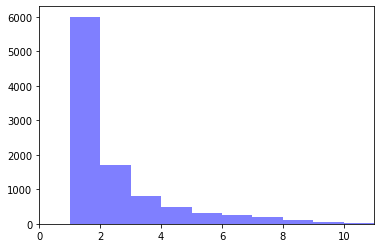

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [139]:
plt.hist(mult,color='b',range=(1,11),bins=10,alpha=0.5)
plt.xlim(0,11)
plt.show()
print(np.unique(mult))

In [140]:
M = len(truths)
q0 = len(truths[truths==0])/M
q1 = len(truths[truths==1])/M
q2 = len(truths[truths==2])/M

print(q0)
print(q1)
print(q2)
print(q0+q1+q2)

entropy = q0*np.log(q0) +  q1*np.log(q1) +  q2*np.log(q2)

print(entropy)

0.23296047725577926
0.2732289336316182
0.49381058911260256
1.0
-1.0423309090980335
